In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('fyp_data/data/diabetic_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (101766, 50)

First few rows:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Load and parse IDS mapping file
def parse_ids_mapping(file_path):
    """
    Parse the IDS_mapping.csv file which contains mappings for multiple ID columns.
    Returns a dictionary with mapping dictionaries for each ID type.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    mappings = {}
    current_id_type = None
    current_mapping = {}
    
    for line in lines:
        line = line.strip()
        
        # Skip empty lines
        if not line or line == ',':
            # If we have a current mapping, save it
            if current_id_type and current_mapping:
                mappings[current_id_type] = current_mapping
                current_mapping = {}
                current_id_type = None
            continue
        
        # Check if this is a header line (id,description format)
        if ',' in line:
            parts = line.split(',', 1)
            if len(parts) == 2 and parts[0].strip().endswith('_id'):
                # Save previous mapping if exists
                if current_id_type and current_mapping:
                    mappings[current_id_type] = current_mapping
                
                # Start new mapping
                current_id_type = parts[0].strip()
                current_mapping = {}
                continue
        
        # Parse mapping entry
        if current_id_type and ',' in line:
            parts = line.split(',', 1)  # Split only on first comma
            if len(parts) == 2:
                try:
                    id_val = int(parts[0].strip())
                    description = parts[1].strip().strip('"')  # Remove quotes if present
                    current_mapping[id_val] = description
                except ValueError:
                    continue
    
    # Save last mapping
    if current_id_type and current_mapping:
        mappings[current_id_type] = current_mapping
    
    return mappings

# Load mappings
mapping_file = 'fyp_data/data/IDS_mapping.csv'
id_mappings = parse_ids_mapping(mapping_file)

print("Loaded ID Mappings:")
print("=" * 50)
for id_type, mapping in id_mappings.items():
    print(f"\n{id_type}: {len(mapping)} mappings")
    print(f"Sample mappings:")
    for k, v in sorted(list(mapping.items()))[:5]:
        print(f"  {k}: {v}")
    if len(mapping) > 5:
        print(f"  ... and {len(mapping) - 5} more")

Loaded ID Mappings:

admission_type_id: 8 mappings
Sample mappings:
  1: Emergency
  2: Urgent
  3: Elective
  4: Newborn
  5: Not Available
  ... and 3 more

discharge_disposition_id: 30 mappings
Sample mappings:
  1: Discharged to home
  2: Discharged/transferred to another short term hospital
  3: Discharged/transferred to SNF
  4: Discharged/transferred to ICF
  5: Discharged/transferred to another type of inpatient care institution
  ... and 25 more

admission_source_id: 25 mappings
Sample mappings:
  1: Physician Referral
  2: Clinic Referral
  3: HMO Referral
  4: Transfer from a hospital
  5: Transfer from a Skilled Nursing Facility (SNF)
  ... and 20 more


In [7]:
# Apply mappings to create new descriptive columns
print("Applying ID Mappings to Dataset:")
print("=" * 50)

# Create new columns with descriptions
for id_col, mapping_dict in id_mappings.items():
    if id_col in df.columns:
        # Create new column name by replacing '_id' with '_description'
        desc_col = id_col.replace('_id', '_description')
        
        # Map the IDs to descriptions
        df[desc_col] = df[id_col].map(mapping_dict)
        
        # Fill any unmapped values with 'Unknown'
        df[desc_col] = df[desc_col].fillna('Unknown')
        
        print(f"✓ Created {desc_col} from {id_col}")
        print(f"  Unique values: {df[desc_col].nunique()}")
        print(f"  Sample values: {df[desc_col].value_counts().head(3).to_dict()}")
        print()

# Show sample of mapped data
print("\nSample of mapped columns:")
mapped_cols = [col for col in df.columns if col.endswith('_description')]
if mapped_cols:
    print(df[['admission_type_id', 'admission_type_description', 
              'discharge_disposition_id', 'discharge_disposition_description',
              'admission_source_id', 'admission_source_description']].head(10))

Applying ID Mappings to Dataset:
✓ Created admission_type_description from admission_type_id
  Unique values: 8
  Sample values: {'Emergency': 53990, 'Elective': 18869, 'Urgent': 18480}

✓ Created discharge_disposition_description from discharge_disposition_id
  Unique values: 26
  Sample values: {'Discharged to home': 60234, 'Discharged/transferred to SNF': 13954, 'Discharged/transferred to home with home health service': 12902}

✓ Created admission_source_description from admission_source_id
  Unique values: 17
  Sample values: {'Emergency Room': 57494, 'Physician Referral': 29565, 'NULL': 6781}


Sample of mapped columns:
   admission_type_id admission_type_description  discharge_disposition_id  \
0                  6                       NULL                        25   
1                  1                  Emergency                         1   
2                  1                  Emergency                         1   
3                  1                  Emergency            

In [8]:
# Basic information about the dataset
print("Dataset Info:")
print("=" * 50)
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes.value_counts())

Dataset Info:
Number of rows: 101,766
Number of columns: 53

Column names:
['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_type_description', 'discharge_disposition_description', 'admission_source_description']

Data ty

In [9]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values Analysis:")
print("=" * 50)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("No missing values found!")

# Check for '?' which might represent missing values
print("\n\nChecking for '?' values (potential missing data indicators):")
print("=" * 50)
question_mark_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        count = (df[col] == '?').sum()
        if count > 0:
            question_mark_cols.append(col)
            print(f"{col}: {count} ({count/len(df)*100:.2f}%)")

if not question_mark_cols:
    print("No '?' values found in the dataset")

Missing Values Analysis:
       Column  Missing Count  Missing Percentage
max_glu_serum          96420           94.746772
    A1Cresult          84748           83.277322


Checking for '?' values (potential missing data indicators):
race: 2273 (2.23%)
weight: 98569 (96.86%)
payer_code: 40256 (39.56%)
medical_specialty: 49949 (49.08%)
diag_1: 21 (0.02%)
diag_2: 358 (0.35%)
diag_3: 1423 (1.40%)


In [10]:
# Summary statistics for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns Summary Statistics:")
print("=" * 50)
df[numerical_cols].describe()

Numerical Columns Summary Statistics:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Target Variable Distribution:
Readmission Status  Count  Percentage
                NO  54864   53.911916
               >30  35545   34.928169
               <30  11357   11.159916


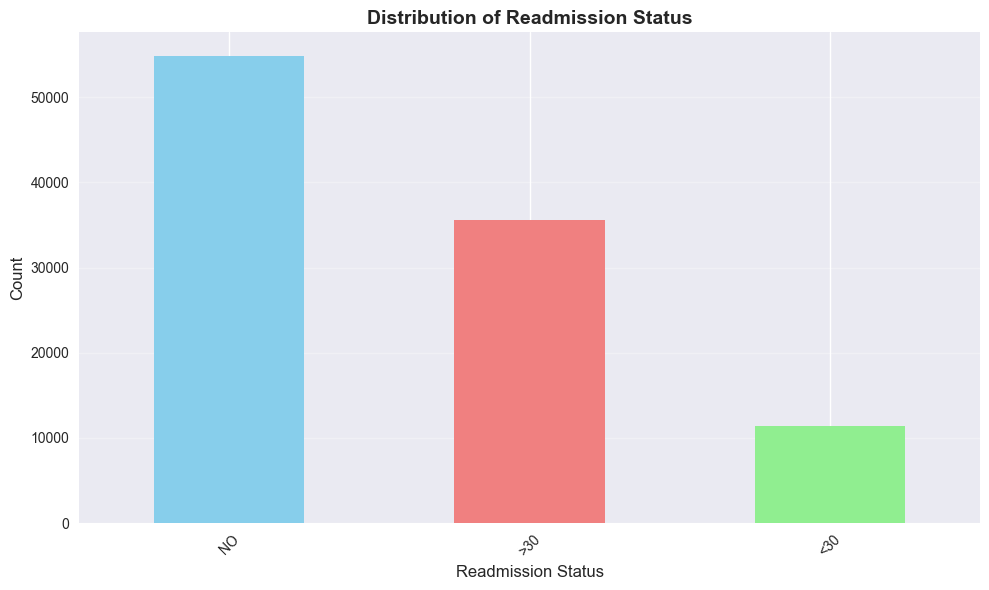

In [11]:
# Target variable analysis (readmitted)
print("Target Variable Distribution:")
print("=" * 50)
target_counts = df['readmitted'].value_counts()
target_percent = df['readmitted'].value_counts(normalize=True) * 100

target_df = pd.DataFrame({
    'Readmission Status': target_counts.index,
    'Count': target_counts.values,
    'Percentage': target_percent.values
})
print(target_df.to_string(index=False))

# Visualize target variable
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Readmission Status', fontsize=14, fontweight='bold')
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Categorical variables analysis
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Remove target variable from categorical analysis
if 'readmitted' in categorical_cols:
    categorical_cols.remove('readmitted')

print("Categorical Variables Analysis:")
print("=" * 50)

# Analyze top categorical variables
for col in categorical_cols[:10]:  # Analyze first 10 categorical columns
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    if df[col].nunique() <= 20:
        print(f"  Value counts:")
        print(df[col].value_counts().head(10))
    else:
        print(f"  Top 10 values:")
        print(df[col].value_counts().head(10))

Categorical Variables Analysis:

race:
  Unique values: 6
  Value counts:
race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

gender:
  Unique values: 3
  Value counts:
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

age:
  Unique values: 10
  Value counts:
age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

weight:
  Unique values: 10
  Value counts:
weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64

payer_code:
  Unique values: 18
  Value counts:
payer_code
?     40256
M

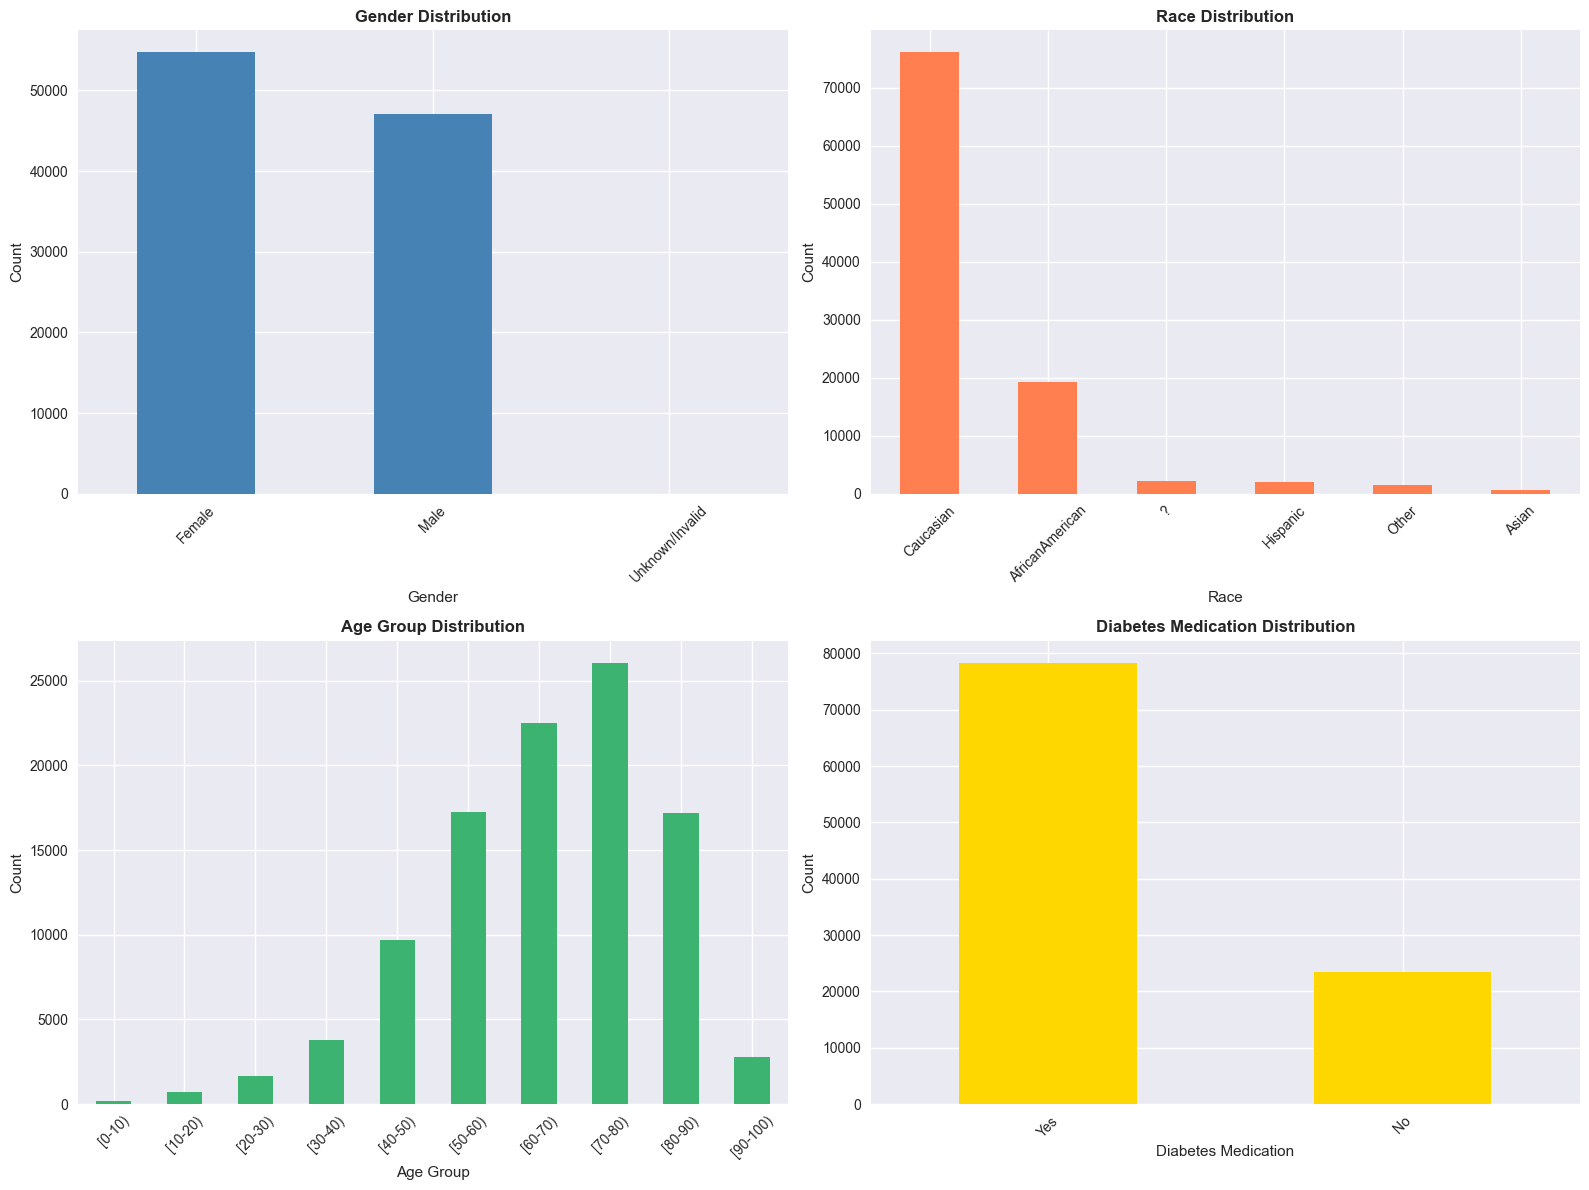

In [13]:
# Visualize key categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gender distribution
if 'gender' in df.columns:
    df['gender'].value_counts().plot(kind='bar', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Gender Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Gender')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)

# Race distribution
if 'race' in df.columns:
    df['race'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Race Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Race')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)

# Age distribution
if 'age' in df.columns:
    df['age'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='mediumseagreen')
    axes[1, 0].set_title('Age Group Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Age Group')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Diabetes medication
if 'diabetesMed' in df.columns:
    df['diabetesMed'].value_counts().plot(kind='bar', ax=axes[1, 1], color='gold')
    axes[1, 1].set_title('Diabetes Medication Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Diabetes Medication')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

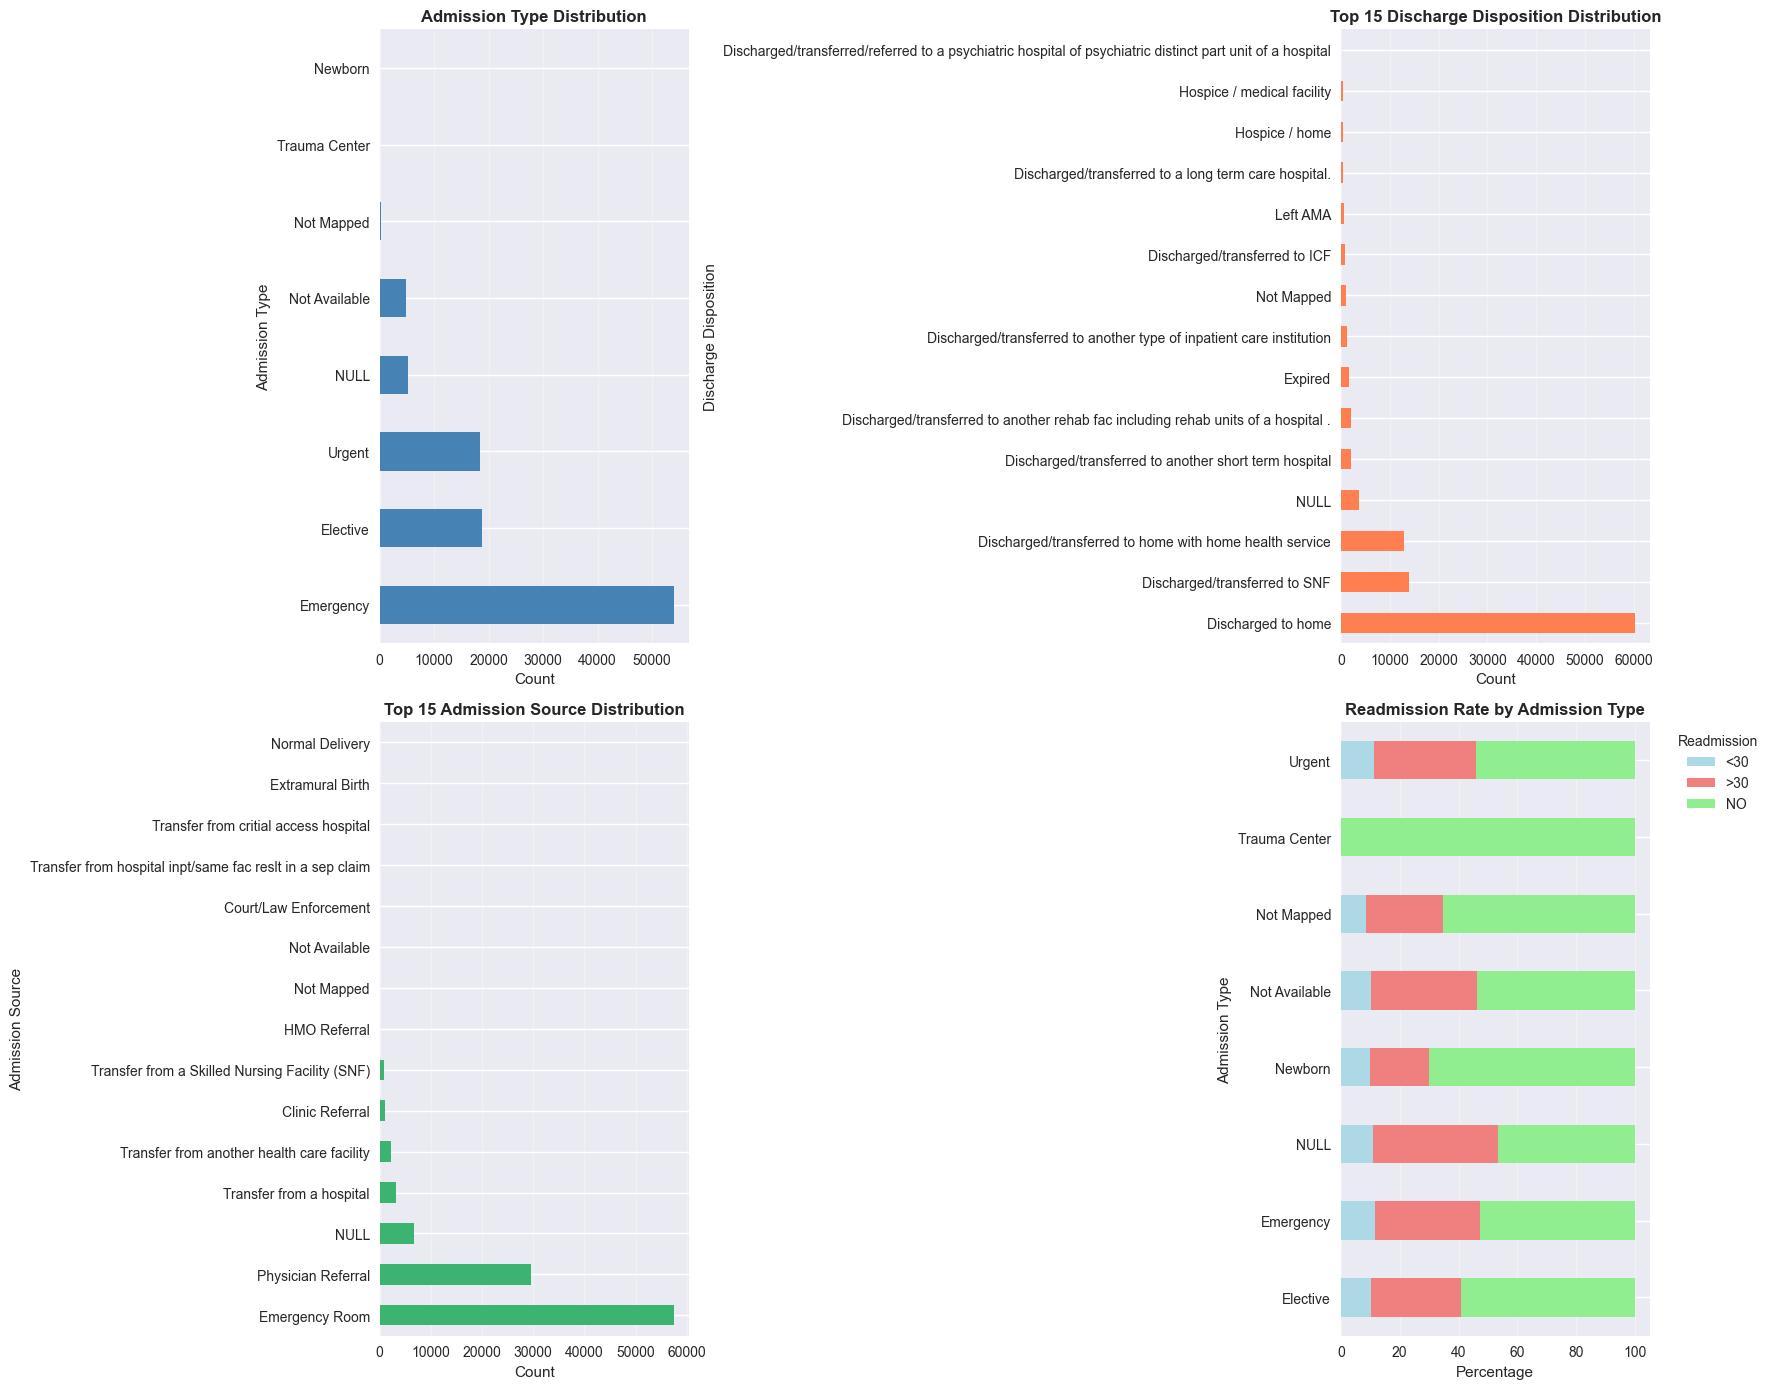

In [14]:
# Visualize mapped ID columns (admission type, discharge disposition, admission source)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Admission Type Distribution
if 'admission_type_description' in df.columns:
    admission_counts = df['admission_type_description'].value_counts()
    admission_counts.plot(kind='barh', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Admission Type Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Count')
    axes[0, 0].set_ylabel('Admission Type')
    axes[0, 0].grid(axis='x', alpha=0.3)

# Discharge Disposition Distribution (Top 15)
if 'discharge_disposition_description' in df.columns:
    discharge_counts = df['discharge_disposition_description'].value_counts().head(15)
    discharge_counts.plot(kind='barh', ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Top 15 Discharge Disposition Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Count')
    axes[0, 1].set_ylabel('Discharge Disposition')
    axes[0, 1].grid(axis='x', alpha=0.3)

# Admission Source Distribution (Top 15)
if 'admission_source_description' in df.columns:
    source_counts = df['admission_source_description'].value_counts().head(15)
    source_counts.plot(kind='barh', ax=axes[1, 0], color='mediumseagreen')
    axes[1, 0].set_title('Top 15 Admission Source Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].set_ylabel('Admission Source')
    axes[1, 0].grid(axis='x', alpha=0.3)

# Readmission by Admission Type
if 'admission_type_description' in df.columns:
    readmit_by_admission = pd.crosstab(df['admission_type_description'], df['readmitted'], normalize='index') * 100
    readmit_by_admission.plot(kind='barh', ax=axes[1, 1], stacked=True,
                              color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[1, 1].set_title('Readmission Rate by Admission Type', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Percentage')
    axes[1, 1].set_ylabel('Admission Type')
    axes[1, 1].legend(title='Readmission', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

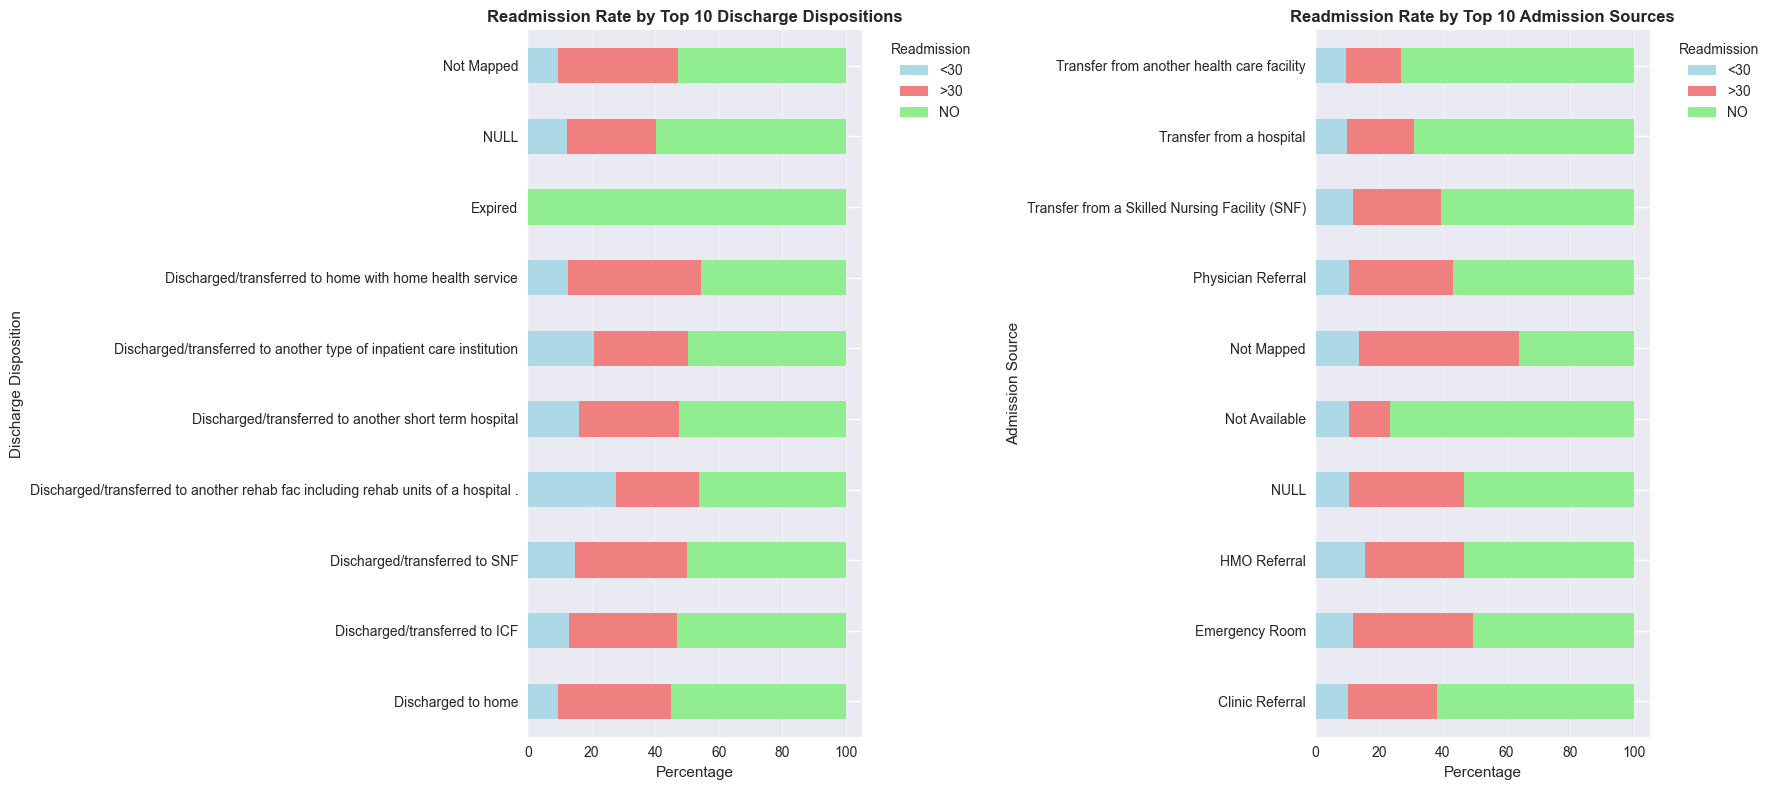

In [15]:
# Readmission rates by discharge disposition (Top 10)
if 'discharge_disposition_description' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Top 10 discharge dispositions
    top_discharge = df['discharge_disposition_description'].value_counts().head(10).index
    
    discharge_readmit = pd.crosstab(
        df[df['discharge_disposition_description'].isin(top_discharge)]['discharge_disposition_description'],
        df[df['discharge_disposition_description'].isin(top_discharge)]['readmitted'],
        normalize='index'
    ) * 100
    
    discharge_readmit.plot(kind='barh', ax=axes[0], stacked=True,
                           color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[0].set_title('Readmission Rate by Top 10 Discharge Dispositions', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Percentage')
    axes[0].set_ylabel('Discharge Disposition')
    axes[0].legend(title='Readmission', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Readmission by admission source (Top 10)
    if 'admission_source_description' in df.columns:
        top_source = df['admission_source_description'].value_counts().head(10).index
        
        source_readmit = pd.crosstab(
            df[df['admission_source_description'].isin(top_source)]['admission_source_description'],
            df[df['admission_source_description'].isin(top_source)]['readmitted'],
            normalize='index'
        ) * 100
        
        source_readmit.plot(kind='barh', ax=axes[1], stacked=True,
                           color=['lightblue', 'lightcoral', 'lightgreen'])
        axes[1].set_title('Readmission Rate by Top 10 Admission Sources', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Percentage')
        axes[1].set_ylabel('Admission Source')
        axes[1].legend(title='Readmission', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

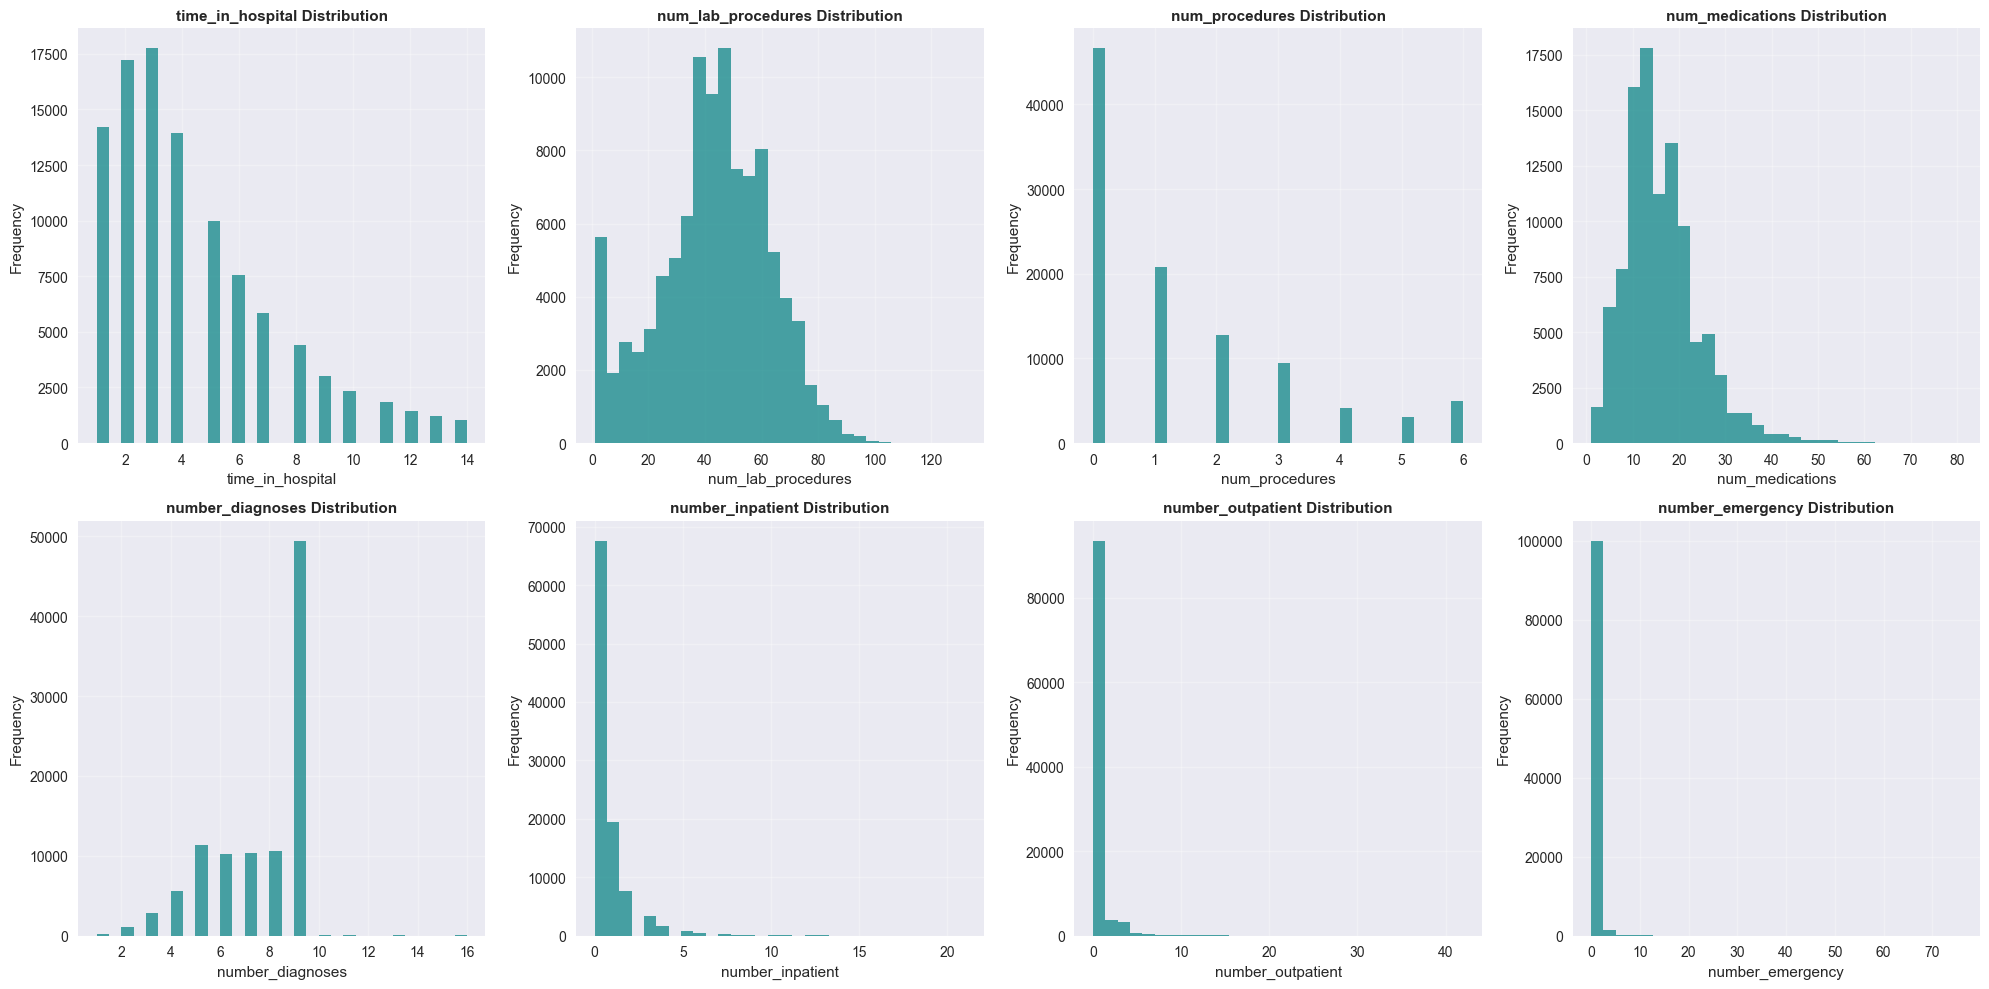

In [16]:
# Numerical variables distribution
key_numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                      'num_medications', 'number_diagnoses', 'number_inpatient',
                      'number_outpatient', 'number_emergency']

# Filter to only include columns that exist in the dataset
key_numerical_cols = [col for col in key_numerical_cols if col in df.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(key_numerical_cols):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], color='teal', alpha=0.7)
        axes[i].set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(alpha=0.3)

# Hide unused subplots
for i in range(len(key_numerical_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

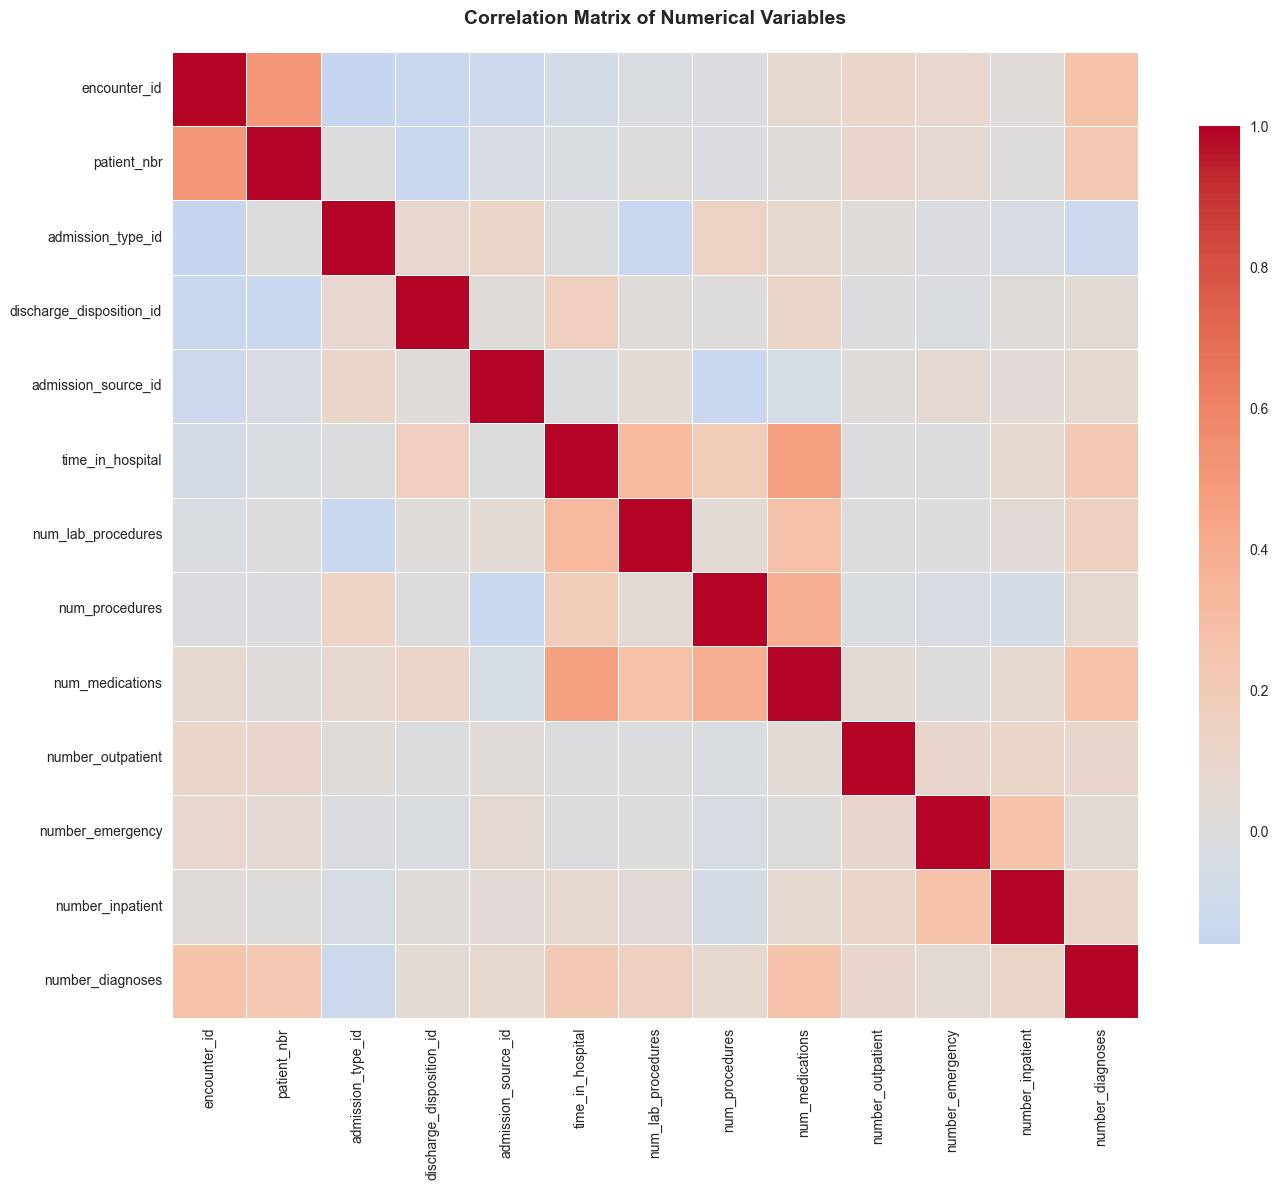


Highly Correlated Variable Pairs (|correlation| > 0.7):
No highly correlated pairs found (threshold: 0.7)


In [17]:
# Correlation analysis for numerical variables
numerical_cols_for_corr = [col for col in numerical_cols if col in df.columns]

# Calculate correlation matrix
corr_matrix = df[numerical_cols_for_corr].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs
print("\nHighly Correlated Variable Pairs (|correlation| > 0.7):")
print("=" * 50)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("No highly correlated pairs found (threshold: 0.7)")

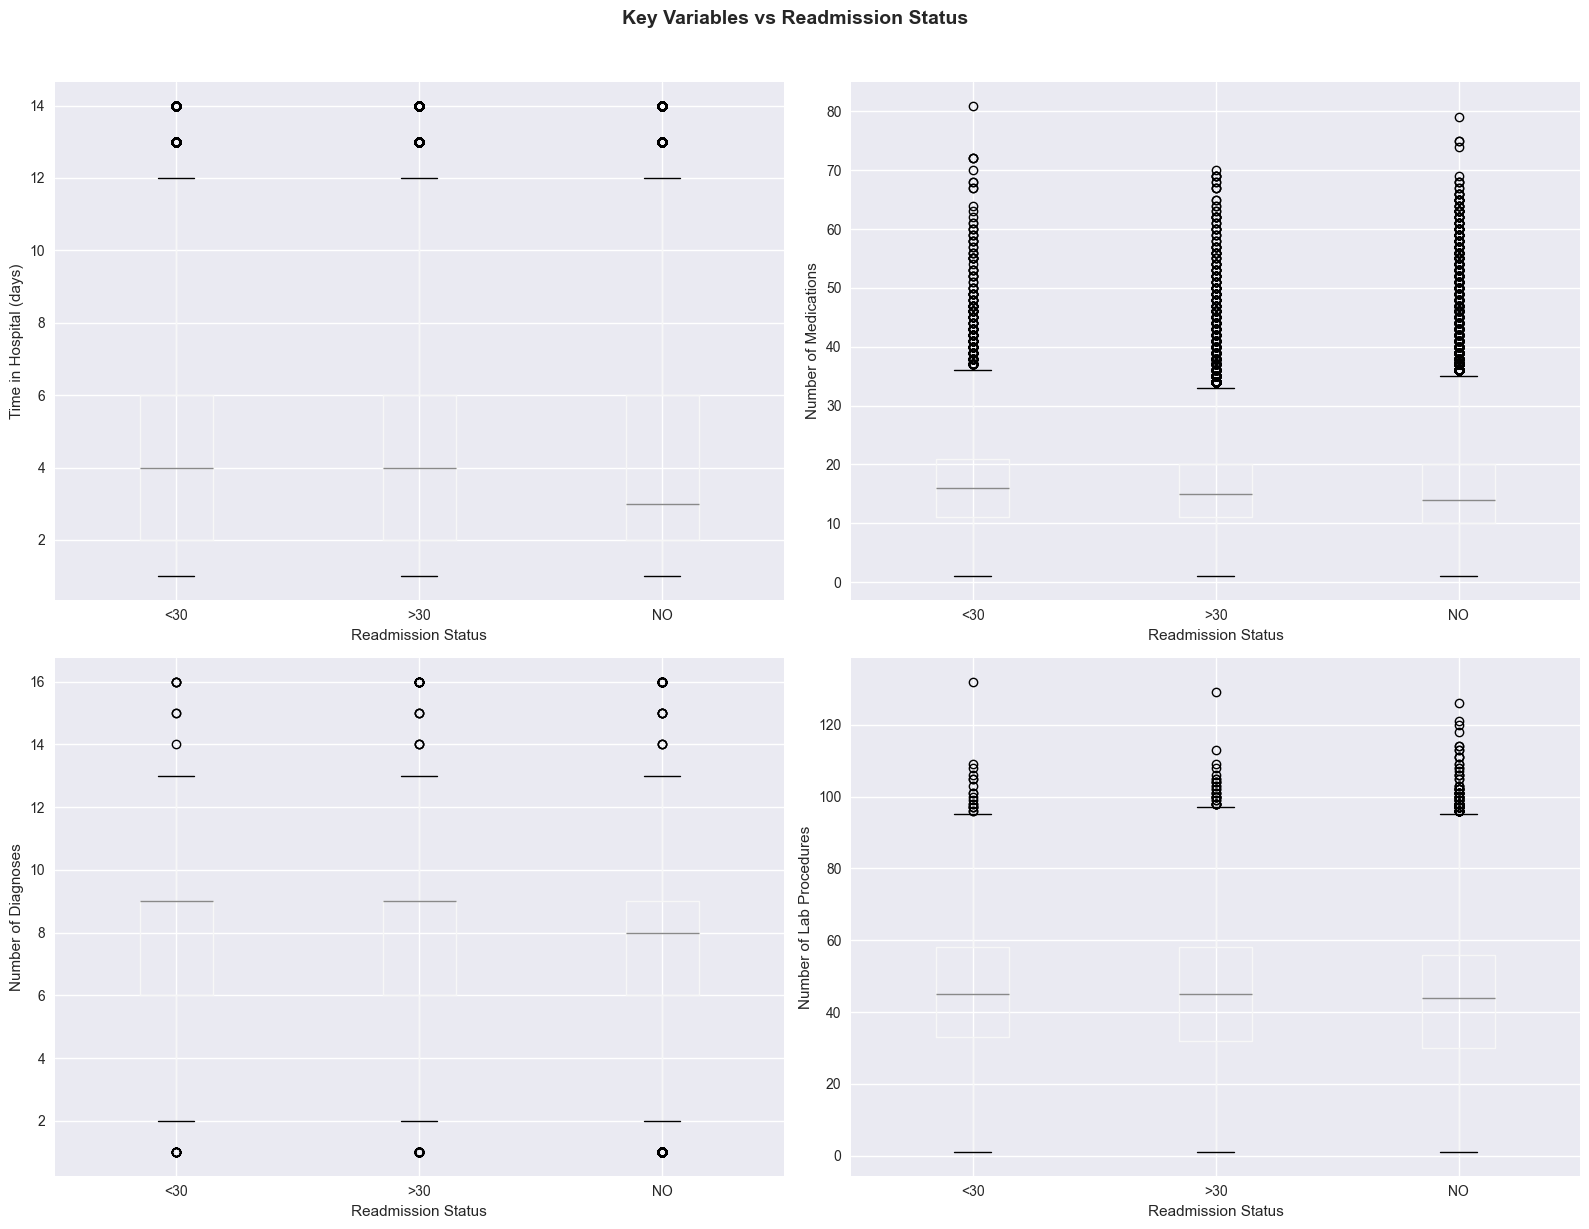

In [18]:
# Relationship between key variables and readmission
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time in hospital vs readmission
if 'time_in_hospital' in df.columns:
    df.boxplot(column='time_in_hospital', by='readmitted', ax=axes[0, 0])
    axes[0, 0].set_title('Time in Hospital by Readmission Status', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Readmission Status')
    axes[0, 0].set_ylabel('Time in Hospital (days)')
    axes[0, 0].set_title('')

# Number of medications vs readmission
if 'num_medications' in df.columns:
    df.boxplot(column='num_medications', by='readmitted', ax=axes[0, 1])
    axes[0, 1].set_title('Number of Medications by Readmission Status', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Readmission Status')
    axes[0, 1].set_ylabel('Number of Medications')
    axes[0, 1].set_title('')

# Number of diagnoses vs readmission
if 'number_diagnoses' in df.columns:
    df.boxplot(column='number_diagnoses', by='readmitted', ax=axes[1, 0])
    axes[1, 0].set_title('Number of Diagnoses by Readmission Status', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Readmission Status')
    axes[1, 0].set_ylabel('Number of Diagnoses')
    axes[1, 0].set_title('')

# Number of lab procedures vs readmission
if 'num_lab_procedures' in df.columns:
    df.boxplot(column='num_lab_procedures', by='readmitted', ax=axes[1, 1])
    axes[1, 1].set_title('Number of Lab Procedures by Readmission Status', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Readmission Status')
    axes[1, 1].set_ylabel('Number of Lab Procedures')
    axes[1, 1].set_title('')

plt.suptitle('Key Variables vs Readmission Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

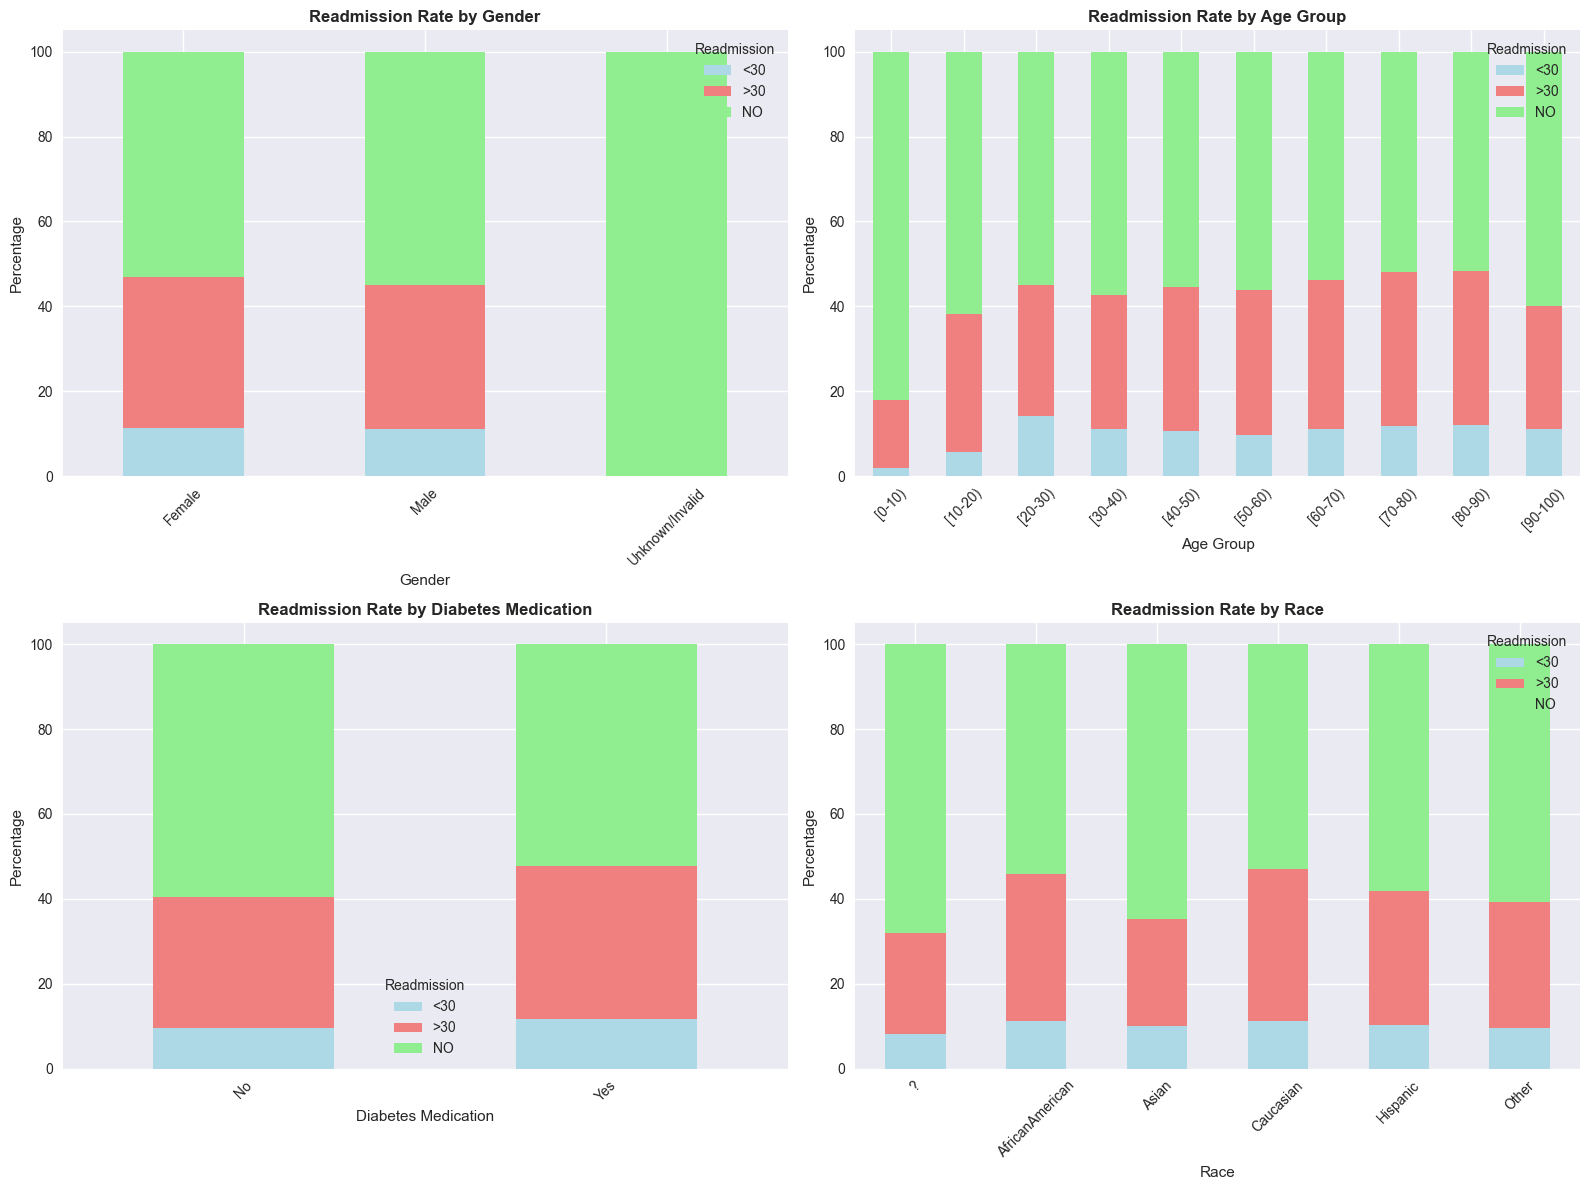

In [19]:
# Readmission rates by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Readmission by gender
if 'gender' in df.columns:
    gender_readmit = pd.crosstab(df['gender'], df['readmitted'], normalize='index') * 100
    gender_readmit.plot(kind='bar', ax=axes[0, 0], stacked=True, 
                        color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[0, 0].set_title('Readmission Rate by Gender', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Gender')
    axes[0, 0].set_ylabel('Percentage')
    axes[0, 0].legend(title='Readmission')
    axes[0, 0].tick_params(axis='x', rotation=45)

# Readmission by age
if 'age' in df.columns:
    age_readmit = pd.crosstab(df['age'], df['readmitted'], normalize='index') * 100
    age_readmit.plot(kind='bar', ax=axes[0, 1], stacked=True,
                     color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[0, 1].set_title('Readmission Rate by Age Group', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Age Group')
    axes[0, 1].set_ylabel('Percentage')
    axes[0, 1].legend(title='Readmission')
    axes[0, 1].tick_params(axis='x', rotation=45)

# Readmission by diabetes medication
if 'diabetesMed' in df.columns:
    med_readmit = pd.crosstab(df['diabetesMed'], df['readmitted'], normalize='index') * 100
    med_readmit.plot(kind='bar', ax=axes[1, 0], stacked=True,
                     color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[1, 0].set_title('Readmission Rate by Diabetes Medication', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Diabetes Medication')
    axes[1, 0].set_ylabel('Percentage')
    axes[1, 0].legend(title='Readmission')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Readmission by race
if 'race' in df.columns:
    race_readmit = pd.crosstab(df['race'], df['readmitted'], normalize='index') * 100
    race_readmit.plot(kind='bar', ax=axes[1, 1], stacked=True,
                      color=['lightblue', 'lightcoral', 'lightgreen'])
    axes[1, 1].set_title('Readmission Rate by Race', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Race')
    axes[1, 1].set_ylabel('Percentage')
    axes[1, 1].legend(title='Readmission')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [20]:
# Summary of key findings
print("=" * 60)
print("EDA SUMMARY - KEY FINDINGS")
print("=" * 60)

print(f"\n1. Dataset Overview:")
print(f"   - Total records: {df.shape[0]:,}")
print(f"   - Total features: {df.shape[1]}")

print(f"\n2. Target Variable (Readmission):")
target_dist = df['readmitted'].value_counts(normalize=True) * 100
for status, pct in target_dist.items():
    print(f"   - {status}: {pct:.2f}%")

print(f"\n3. Data Quality:")
missing_count = df.isnull().sum().sum()
print(f"   - Missing values: {missing_count}")
if '?' in df.values:
    print(f"   - '?' values found: Yes (may need encoding)")

print(f"\n4. Numerical Features:")
print(f"   - Count: {len(numerical_cols)}")
print(f"   - Key features: time_in_hospital, num_medications, number_diagnoses, etc.")

print(f"\n5. Categorical Features:")
print(f"   - Count: {len(categorical_cols)}")
print(f"   - Key features: gender, race, age, diabetesMed, etc.")

print("\n" + "=" * 60)

EDA SUMMARY - KEY FINDINGS

1. Dataset Overview:
   - Total records: 101,766
   - Total features: 53

2. Target Variable (Readmission):
   - NO: 53.91%
   - >30: 34.93%
   - <30: 11.16%

3. Data Quality:
   - Missing values: 181168
   - '?' values found: Yes (may need encoding)

4. Numerical Features:
   - Count: 13
   - Key features: time_in_hospital, num_medications, number_diagnoses, etc.

5. Categorical Features:
   - Count: 39
   - Key features: gender, race, age, diabetesMed, etc.

